In [1]:
# Loads the different libraries
import pandas as pd
import numpy as np
from google.cloud import bigquery
import igraph as ig
# Starts the client
client = bigquery.Client(location="US")
import seaborn as sns
from datetime import timedelta
from shapely import wkt
import matplotlib.pyplot as plt
import re
                                       
import geopandas
import contextily as ctx

date_format = "%Y-%m-%d"

import sys
sys.path.append("../")

import functions.utils as utils

ModuleNotFoundError: No module named 'igraph'

In [2]:
## Contacts

In [ ]:
poly_text = "POLYGON ((-72.519459 7.892871,-72.511416 7.908612,-72.500419 7.899882,-72.504750 7.886777,-72.519459 7.892871))"
distance = 500 # Meters

query = f"""
        SELECT *
        FROM edgelists_cities.colombia_cucuta
        WHERE ST_DWITHIN(ST_GEOGFROMTEXT("{poly_text}"),
                            ST_GeogPoint(lon, lat), {distance})

"""

job_config = bigquery.QueryJobConfig(allow_large_results = True)
query_job = client.query(query, job_config=job_config) 

# Return the results as a pandas DataFrame
df = query_job.to_dataframe()


## Centralities

In [2]:
from sklearn.preprocessing import MinMaxScaler


def scale(values, min_val, max_val):
    scaler = MinMaxScaler(feature_range = (min_val,max_val))
    scaler.fit(values.reshape(-1, 1))
    return(scaler.transform(values.reshape(-1, 1))[:,0])



report_name = 'report_norte_de_santander' 
location_id = 'colombia_cucuta'
attribute_name = 'pagerank_centrality'
attribute_publication_name = 'Centralidad Pagerank'
num_top = 5000

min_date = pd.to_datetime('2020-08-02')
max_date = pd.to_datetime('2020-08-28')


min_date_str = min_date.strftime(utils.date_format)
max_date_str = max_date.strftime(utils.date_format)

max_node_size = 10
min_node_size = 4

# Gets the nodes with housing location

query = f"""

        SELECT h.identifier, 
               nodes.attribute_value,
               h.lon, 
               h.lat, 
               h.type,
               ST_DWithin(ST_GeogPoint(h.lon, h.lat),
                    (SELECT geometry 
                    FROM grafos-alcaldia-bogota.geo.locations_geometries 
                    WHERE location_id = "{location_id}"),
                    (SELECT precision 
                    FROM grafos-alcaldia-bogota.geo.locations_geometries 
                    WHERE location_id = "{location_id}")) as inside
        FROM 
        (SELECT identifier, AVG(attribute_value) as attribute_value
        FROM grafos-alcaldia-bogota.graph_attributes.node_attributes
        WHERE location_id = "{location_id}"
              AND attribute_name = "{attribute_name}"
              AND date >= "{min_date_str}" 
              AND date <= "{max_date_str}"
        GROUP BY identifier) as nodes
        JOIN 
        (SELECT *
        FROM housing_location.colombia_housing_location
        WHERE week_date >= "{min_date_str}" 
                AND week_date <= "{max_date_str}") as h
        ON nodes.identifier = h.identifier

"""


job_config = bigquery.QueryJobConfig(allow_large_results=True)
query_job = client.query(query, job_config=job_config) 

# Return the results as a pandas DataFrame
df = query_job.to_dataframe()

Text(0.5, 1.0, 'Casas de Dispositivos Centrales (Centralidad Pagerank)')

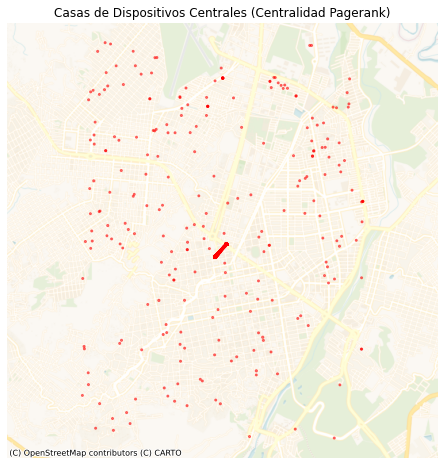

In [14]:


# Converts to geopandas
df_plot = df[(df['type'] == 'HOUSE') & (df.inside)]
df_plot = df_plot.sort_values('attribute_value', ascending = False).drop_duplicates(subset = 'identifier', keep = 'first')
df_plot = df_plot.head(min(num_top, df.shape[0]))

#Removes outliers
dif = 2.5
df_plot = df_plot[ np.abs(df_plot.lon - df_plot.lon.mean()) < dif*df_plot.lon.std()].copy()
df_plot = df_plot[ np.abs(df_plot.lat - df_plot.lat.mean()) < dif*df_plot.lat.std()].copy()


geo_df = geopandas.GeoDataFrame(df_plot, crs =  "EPSG:4326", geometry=geopandas.points_from_xy(df_plot.lon, df_plot.lat))
geo_df = geo_df.to_crs(epsg=3857)


# Constructs Squares
lon_center = (geo_df.lon.max() - geo_df.lon.min())/2 + geo_df.lon.min()
lat_center = (geo_df.lat.max() - geo_df.lat.min())/2 + geo_df.lat.min()
rad = max(geo_df.lon.max() - geo_df.lon.min(), geo_df.lat.max() - geo_df.lat.min())/2

left = min(geo_df.lon.min(), lon_center - rad)
right = max(geo_df.lon.max(), lon_center + rad)

bottom = min(geo_df.lat.min(), lat_center - rad)
top = max(geo_df.lat.max(), lat_center + rad)

margins = pd.DataFrame({'lon':[left,left,right,right], 'lat':[top,bottom,top,bottom]})
margins = geopandas.GeoDataFrame(margins, crs =  "EPSG:4326", geometry=geopandas.points_from_xy(margins.lon, margins.lat))
margins = margins.to_crs(epsg=3857)


# Adjust size
geo_df['markersize'] = scale(geo_df.attribute_value.values, min_node_size, max_node_size)


#source=ctx.providers.CartoDB.VoyagerNoLabels)

ax = geo_df.plot(figsize=(8,8), alpha= 0.5, markersize = 'markersize', color = 'red')
# adds margins
margins.plot(alpha=0.0, markersize = 1, color = 'white', ax = ax)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.VoyagerNoLabels)
ax.set_axis_off()
ax.set_title(f'Casas de Dispositivos Centrales ({attribute_publication_name})')

In [13]:
geo_df.lon.max() - geo_df.lon.min() + rad

0.07109773333333713

In [9]:
margins

,lon,lat,geometry
0,-72.527673,7.925631,POINT (-8073743.622 885104.427)
1,-72.527673,0.029234,POINT (-8073743.622 3254.289)
2,0.071098,7.925631,POINT (7914.563 885104.427)
3,0.071098,0.029234,POINT (7914.563 3254.289)


In [123]:
for k in ctx.providers.Esri:
    print(k)

WorldStreetMap
DeLorme
WorldTopoMap
WorldImagery
WorldTerrain
WorldShadedRelief
WorldPhysical
OceanBasemap
NatGeoWorldMap
WorldGrayCanvas


## Transits 

In [161]:


report_name = 'report_norte_de_santander' 
location_id = 'colombia_bogota' 
min_date = pd.to_datetime('2020-05-01')
max_date = pd.to_datetime('2020-05-17')
precision = 3000


min_date_str = min_date.strftime(utils.date_format)
max_date_str = max_date.strftime(utils.date_format)

# Gets the nodes with housing location

query = f"""

        SELECT h.identifier, 
               h.lon, 
               h.lat, 
               h.type,
               ST_DWithin(ST_GeogPoint(h.lon, h.lat),
                    (SELECT geometry 
                    FROM grafos-alcaldia-bogota.geo.locations_geometries 
                    WHERE location_id = "{location_id}"),
                    (SELECT precision 
                    FROM grafos-alcaldia-bogota.geo.locations_geometries 
                    WHERE location_id = "{location_id}")) as inside
        FROM 
        (SELECT identifier
        FROM grafos-alcaldia-bogota.transits.hourly_transits
        WHERE location_id = "{location_id}"
              AND date >= "{min_date_str}" 
              AND date <= "{max_date_str}"
              

        GROUP BY identifier) as nodes
        JOIN 
        (SELECT *
        FROM housing_location.colombia_housing_location
        WHERE week_date >= "{min_date_str}" 
                AND week_date <= "{max_date_str}") as h
        ON nodes.identifier = h.identifier

"""


job_config = bigquery.QueryJobConfig(allow_large_results=True)
query_job = client.query(query, job_config=job_config) 

# Return the results as a pandas DataFrame
df = query_job.to_dataframe()

df

,identifier,lon,lat,type,inside
0,38ae8ea8-2ed8-4337-ac15-d29033100c7d,-75.617702,6.244244,WORK,False
1,821af536-3d65-4072-b254-5bc4b6cbaece,-75.561499,6.249237,WORK,False
2,075780af-8819-4705-b89d-e81313a2a9ef,-76.728432,8.098925,WORK,False
3,af2a50f0-efe9-4f51-bbde-84f2b91ea2c6,-75.449048,6.018413,WORK,False
4,de564e07-3cb4-44d4-ba10-f2ecb522d863,-75.581907,6.300750,WORK,False
...,...,...,...,...,...
330201,00097e39-f3bf-46e4-a5e2-a0e28e07efdd,-74.818138,10.414414,COMMON,False
330202,7c27ba73-2585-455a-8ba7-6c1820b6297a,-74.616200,10.461700,COMMON,False
330203,2d2d93cc-7a0e-4b27-97d6-d46df9b00a8a,-73.970508,9.018143,COMMON,False
330204,4056649f-471d-4c3f-a236-696674ce09dc,-74.352142,9.235498,COMMON,False


Text(0.5, 1.0, 'Casas de Dispositivos Transitorios (Nacional)')

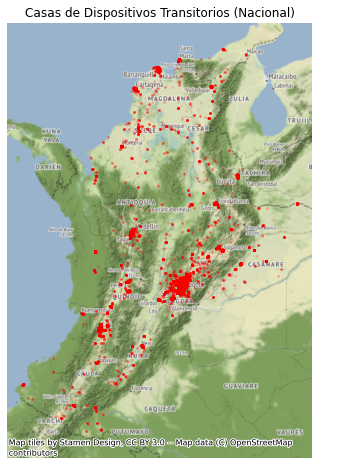

In [162]:
# Converts to geopandas
df_plot = df
geo_df = geopandas.GeoDataFrame(df_plot, crs =  "EPSG:4326", geometry=geopandas.points_from_xy(df_plot.lon, df_plot.lat))
geo_df = geo_df.to_crs(epsg=3857)


ax = geo_df.plot(figsize=(8,8), alpha=0.1, markersize = 3, color = 'red')
ctx.add_basemap(ax)
ax.set_axis_off()
ax.set_title('Casas de Dispositivos Transitorios (Nacional)')


Text(0.5, 1.0, 'Casas de Dispositivos Transitorios (Local)')

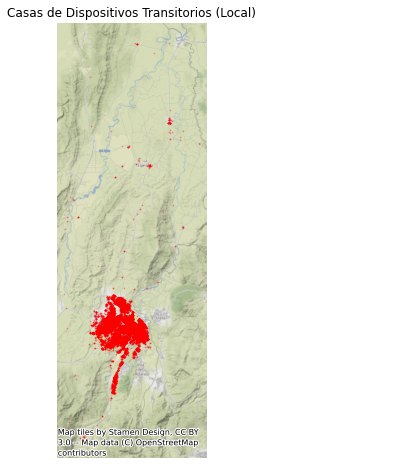

In [60]:
# Converts to geopandas
df_plot = df[df.inside]
geo_df = geopandas.GeoDataFrame(df_plot, crs =  "EPSG:4326", geometry=geopandas.points_from_xy(df_plot.lon, df_plot.lat))
geo_df = geo_df.to_crs(epsg=3857)


ax = geo_df.plot(figsize=(8,8), alpha=0.3, markersize = 0.5, color = 'red')
ctx.add_basemap(ax)
ax.set_axis_off()
ax.set_title('Casas de Dispositivos Transitorios (Local)')


In [7]:
all_locations = utils.get_current_locations(client, only_active = False).location_id.values.tolist()

regex = re.compile('colombia_palmira_comuna_*')
locations_ids = list(filter(regex.search, all_locations))

print(locations_ids)

['colombia_palmira_comuna_3', 'colombia_palmira_comuna_2', 'colombia_palmira_comuna_1', 'colombia_palmira_comuna_5', 'colombia_palmira_comuna_7', 'colombia_palmira_comuna_4', 'colombia_palmira_comuna_6']


In [2]:
sql = """
    SELECT *
    FROM graph_attributes.graph_sizes
    WHERE location_id LIKE "colombia_bogota_%"
    
"""
df = utils.run_simple_query(client, sql)
df

,location_id,date,num_nodes,num_edges
0,colombia_bogota_localidad_sumapaz,2020-05-03,135,1
1,colombia_bogota_localidad_engativa,2020-05-03,33343,32540
2,colombia_bogota_localidad_los_martires,2020-05-03,22070,1664325
3,colombia_bogota_localidad_chapinero,2020-05-03,27299,305222
4,colombia_bogota_localidad_usaquen,2020-05-03,29130,17525
...,...,...,...,...
555,colombia_bogota_localidad_teusaquillo,2020-04-12,10238,985
556,colombia_bogota_localidad_puente_aranda,2020-04-12,17964,10713
557,colombia_bogota_localidad_suba,2020-04-12,49006,18912
558,colombia_bogota_localidad_antonio_narino,2020-04-12,8170,3062


In [8]:
df_plot = df[df.date >= pd.to_datetime('2020-04-01')]
#df_plot = df

<AxesSubplot:xlabel='date', ylabel='num_edges'>

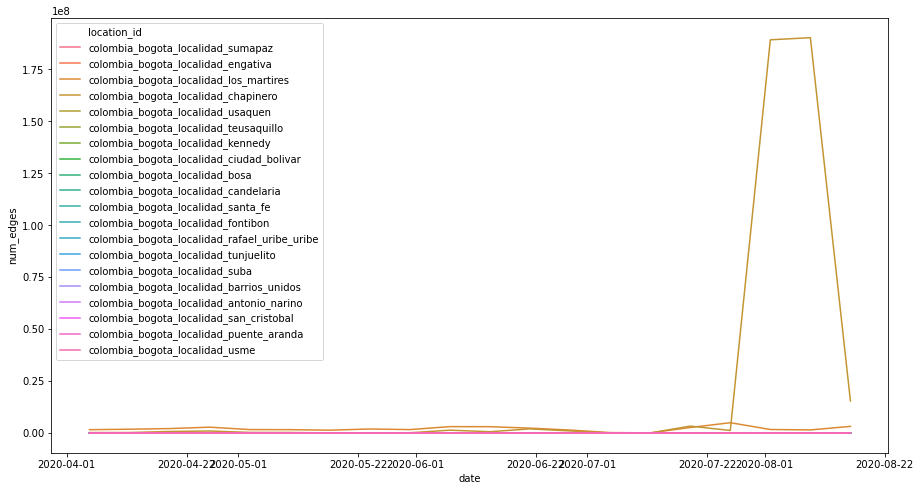

In [9]:
plt.figure(figsize=(15,8))
sns.lineplot(x = 'date', y = 'num_edges', hue = 'location_id', data = df_plot)

In [12]:
df.groupby('location_id').sum().reset_index().sort_values('num_edges')

,location_id,num_nodes,num_edges
15,colombia_bogota_localidad_sumapaz,4588,10
16,colombia_bogota_localidad_teusaquillo,434002,62708
0,colombia_bogota_localidad_antonio_narino,283210,107912
12,colombia_bogota_localidad_san_cristobal,369033,116825
1,colombia_bogota_localidad_barrios_unidos,405905,184551
10,colombia_bogota_localidad_puente_aranda,592180,290990
7,colombia_bogota_localidad_fontibon,672321,335549
11,colombia_bogota_localidad_rafael_uribe_uribe,586018,362506
19,colombia_bogota_localidad_usme,497679,400515
6,colombia_bogota_localidad_engativa,925403,411918


In [164]:
sql = """
    SELECT *
    FROM graph_attributes.graph_movement
    WHERE location_id LIKE "colombia_bogota"
"""

df_mov = utils.run_simple_query(client, sql)

df_mov

,location_id,date,all_devices,devices_with_movement,devices_stayed_in,devices_traveled_outside,percentaga_stayed_in,percentaga_treveled_outside,all_movement,all_movement_avg,inner_movement,inner_movement_avg,outer_movement,outer_movement_avg
0,colombia_bogota,2020-03-22,106989,40939,105600,1389,0.987017,0.012983,61301.857158,1.497395,51311.200950,1.282620,6610.768164,5.758509
1,colombia_bogota,2020-02-01,96931,33994,94090,2841,0.970690,0.029310,159738.767372,4.699028,134732.423423,4.131882,20342.488971,7.839109
2,colombia_bogota,2020-05-10,109496,45821,108023,1473,0.986547,0.013453,80093.634570,1.747968,70829.535692,1.579254,5818.250929,4.673294
3,colombia_bogota,2020-07-27,55646,33618,54523,1123,0.979819,0.020181,97260.822695,2.893117,86939.330750,2.614953,7552.443743,7.448169
4,colombia_bogota,2020-08-08,160488,27032,159060,1428,0.991102,0.008898,74005.498207,2.737700,65442.168570,2.502473,7007.649650,5.145117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,colombia_bogota,2020-02-27,110433,47715,107452,2981,0.973006,0.026994,228556.146812,4.790027,202439.630645,4.356726,20996.328559,7.512103
206,colombia_bogota,2020-05-06,115775,54318,113554,2221,0.980816,0.019184,125145.025776,2.303933,108443.263872,2.043786,12238.744873,6.094992
207,colombia_bogota,2020-05-07,108135,49003,105988,2147,0.980145,0.019855,122235.329414,2.494446,103341.165927,2.159464,13646.242932,7.159624
208,colombia_bogota,2020-06-19,92617,38018,90388,2229,0.975933,0.024067,129632.160632,3.409757,110819.406542,3.001690,14128.514220,7.046641


<AxesSubplot:xlabel='date', ylabel='all_movement'>

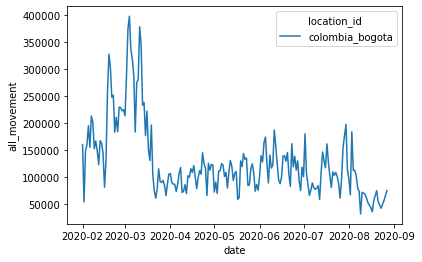

In [165]:
sns.lineplot(data = df_mov, x = 'date', y = 'all_movement', hue = 'location_id')

# Shapefiles

In [104]:
sql = """
    SELECT *
    FROM geo.locations_geometries
"""

df = utils.run_simple_query(client, sql)
df['geometry'] = df['geometry'].apply(wkt.loads)
polygons = geopandas.GeoDataFrame(df, geometry = 'geometry')
polygons

,location_id,country,name,geometry,precision,dataset,type
0,colombia_cali,Colombia,Cali,"POLYGON ((-76.59200 3.54696, -76.59329 3.54736...",1000.000000000,edgelists_cities,city
1,colombia_leticia,Colombia,Leticia,"POLYGON ((-69.74139 -3.00263, -69.74193 -3.002...",1000.000000000,edgelists_cities,city
2,colombia_palmira,Colombia,Palmira,"POLYGON ((-75.98010 3.71759, -75.98011 3.71760...",1000.000000000,edgelists_cities,city
3,colombia_cucuta,Colombia,Cucuta,"POLYGON ((-72.47780 8.43060, -72.47780 8.43067...",1000.000000000,edgelists_cities,city
4,colombia_norte_de_santander,Colombia,Norte de Santander,"POLYGON ((-73.00345 9.28181, -73.00314 9.28273...",1000.000000000,edgelists_states,state
5,peru_lima,Peru,Lima,"MULTIPOLYGON (((-76.78110 -12.40911, -76.78119...",1000.000000000,edgelists_cities,city
6,colombia_medellin,Colombia,Medellin,"POLYGON ((-75.67007 6.37367, -75.67023 6.37371...",1000.000000000,edgelists_cities,city
7,colombia_cartagena,Colombia,Cartagena,"MULTIPOLYGON (((-75.65453 10.17245, -75.65464 ...",1000.000000000,edgelists_cities,city
8,colombia_barranquilla,Colombia,Barranquilla,"POLYGON ((-74.84954 11.09802, -74.84962 11.098...",1000.000000000,edgelists_cities,city
9,colombia_bogota,Colombia,Bogota,"POLYGON ((-74.07351 4.83624, -74.07407 4.83663...",1000.000000000,edgelists_cities,city


<AxesSubplot:>

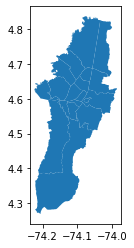

In [105]:
polygons = polygons[polygons['type'] == 'locality']
polygons = polygons[polygons.location_id != 'colombia_bogota_localidad_sumapaz'].copy()

polygons['label'] = polygons['name'].apply(lambda s: s.replace('Bogotá Localidad', ''))
polygons.plot()

## Gets The Movment


In [106]:
sql = """
    SELECT *
    FROM graph_attributes.graph_movement
"""

df_mov = utils.run_simple_query(client, sql)

In [107]:
df_mov = df_mov[df_mov.location_id.isin(polygons.location_id)].copy()
df_mov

,location_id,date,all_devices,devices_with_movement,devices_stayed_in,devices_traveled_outside,percentaga_stayed_in,percentaga_treveled_outside,all_movement,all_movement_avg,inner_movement,inner_movement_avg,outer_movement,outer_movement_avg
2702,colombia_bogota_localidad_bosa,2020-04-22,14479,5928,12250,2229,0.846053,0.153947,25928.496523,4.373903,1548.371962,0.350073,8466.137152,5.529809
2703,colombia_bogota_localidad_bosa,2020-03-01,14638,7804,10980,3658,0.750102,0.249898,42769.836401,5.480502,2885.713339,0.513929,15847.193935,6.111529
2704,colombia_bogota_localidad_bosa,2020-07-31,4926,3461,3578,1348,0.726350,0.273650,18589.312915,5.371081,1020.102509,0.362124,6728.377314,6.708253
2705,colombia_bogota_localidad_bosa,2020-05-03,12754,5529,10954,1800,0.858868,0.141132,18133.887729,3.279777,1461.973754,0.335623,4708.175664,3.926752
2706,colombia_bogota_localidad_bosa,2020-03-14,13321,6741,9685,3636,0.727048,0.272952,46117.347196,6.841321,2490.885878,0.544337,17428.199636,6.542117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7908,colombia_bogota_localidad_rafael_uribe_uribe,2020-03-21,6552,2721,5547,1005,0.846612,0.153388,9677.020637,3.556421,430.427392,0.218936,3950.842287,6.173191
7909,colombia_bogota_localidad_rafael_uribe_uribe,2020-06-05,7711,4281,5467,2244,0.708987,0.291013,25031.768086,5.847178,1117.270869,0.369835,11507.081121,6.701853
7910,colombia_bogota_localidad_rafael_uribe_uribe,2020-02-29,7260,3969,4761,2499,0.655785,0.344215,28843.677319,7.267240,965.208273,0.387012,13599.447067,7.288021
7911,colombia_bogota_localidad_rafael_uribe_uribe,2020-06-06,6647,3376,4865,1782,0.731909,0.268091,18766.565712,5.558817,875.486781,0.373980,8124.216514,6.192238


# Plots

In [108]:
min_date = pd.to_datetime('2020-07-01')
max_date = pd.to_datetime('2020-08-01')

In [109]:
def make_plot(min_date, max_date, col, title, cmap = 'OrRd', labels = True):
    df_sel = df_mov.loc[(df_mov.date >= min_date) & (df_mov.date <= max_date),['location_id',col]].groupby('location_id').mean().reset_index()

    df_plot = polygons.merge(df_sel, on = 'location_id')

    fig = plt.figure(figsize=(19,8))
    
    if 'percenta' in col:
        df_plot[col] = df_plot[col]*100

    ax = df_plot.plot(column = col, legend = True, cmap=cmap, figsize=(15, 15))
    ax.set_title(title, fontsize = 16)
    ax.set_axis_off()
    if labels:
        df_plot.apply(lambda p: ax.text(s=p['label'], x=p.geometry.centroid.coords[0][0], y = p.geometry.centroid.coords[0][1], ha='center'),axis=1)
    
    plt.show()
    

<Figure size 1368x576 with 0 Axes>

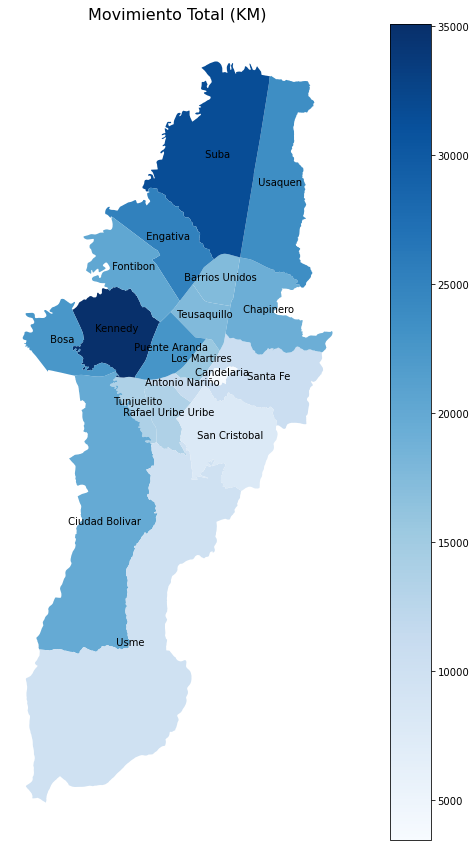

In [110]:
col = 'all_movement'
title = 'Movimiento Total (KM)'
make_plot(min_date, max_date, col, title, 'Blues')

<Figure size 1368x576 with 0 Axes>

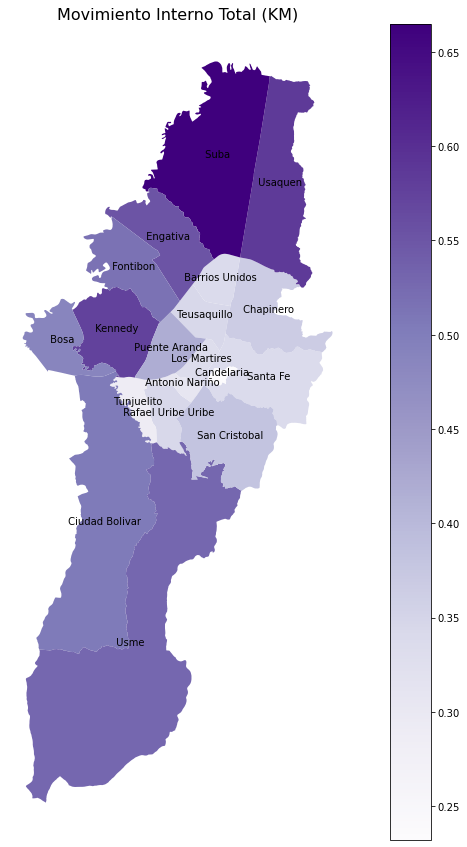

In [112]:
col = 'inner_movement_avg'
title = 'Movimiento Interno Promedio (KM)'
make_plot(min_date, max_date, col, title, 'Purples')

<Figure size 1368x576 with 0 Axes>

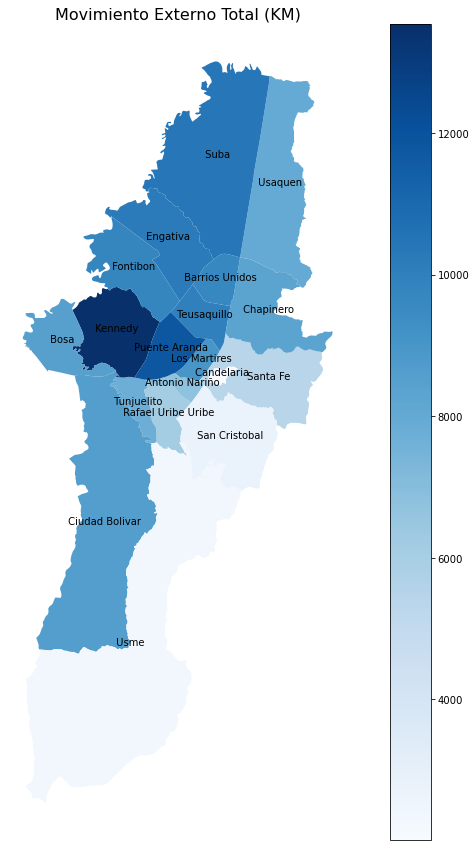

In [102]:
col = 'outer_movement'
title = 'Movimiento Externo Total (KM)'
make_plot(min_date, max_date, col, title, 'Blues')

<Figure size 1368x576 with 0 Axes>

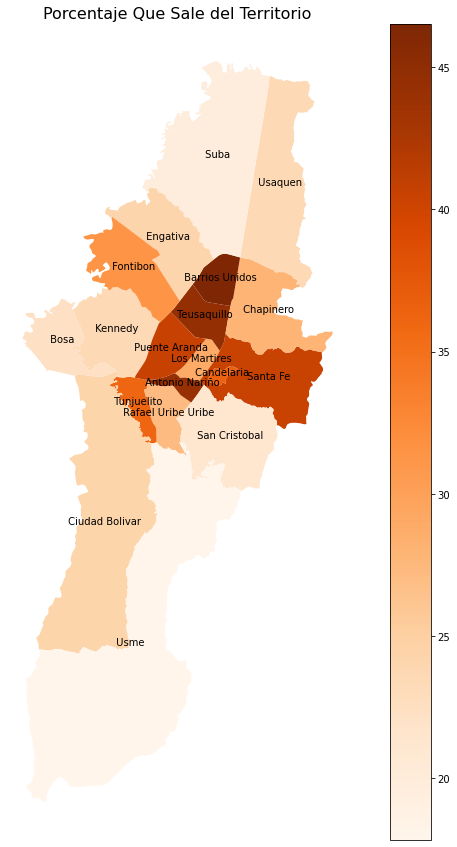

In [100]:
col = 'percentaga_treveled_outside'
title = 'Porcentaje Que Sale del Territorio'
make_plot(min_date, max_date, col, title, 'Oranges')

<Figure size 1368x576 with 0 Axes>

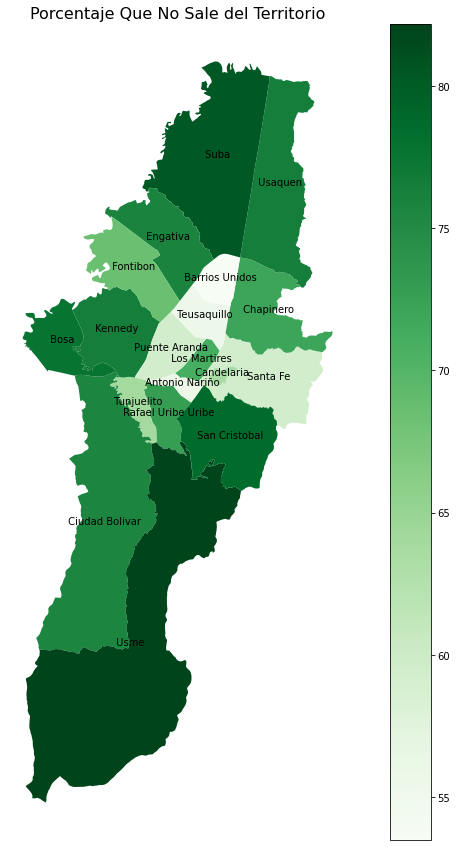

In [101]:
col = 'percentaga_stayed_in'
title = 'Porcentaje Que No Sale del Territorio'
make_plot(min_date, max_date, col, title, 'Greens')